### GAN 논문 구현

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader


import argparse
import os
import numpy as np
import math

In [2]:
## random seed initialization ##
seed = 0
torch.manual_seed(seed)

# parameter
parser = argparse.ArgumentParser(description='HyperParameters of GAN')
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
args = parser.parse_args('')
print(args)

Namespace(n_epochs=200, batch_size=64, lr=0.0002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, img_size=28, channels=1, sample_interval=400)


In [3]:
img_shape = (args.channels, args.img_size, args.img_size) # channel, W, H
CUDA = True if torch.cuda.is_available() else False

In [4]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    
    # 블록 정의
    def block(input_dim, ouput_dim, normalize=True):
      layers=[nn.Linear(input_dim, ouput_dim)]
      if normalize:
        layers.append(nn.BatchNorm1d(ouput_dim, 0.8))
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      return layers

    # 모델 정의(Encoder 역할)
    self.model = nn.Sequential(
      *block(args.latent_dim, 128, normalize=False),
      *block(128, 256),
      *block(256, 512),
      *block(512, 1024),
      nn.Linear(1024, int(np.prod(img_shape))),
      nn.Tanh()
    )

  def forward(self, z):
    img = self.model(z)
    img = img.view(img.size(0), *img_shape) # batch_size, channel, W, H
    return img

In [5]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(int(np.prod(img_shape)), 512),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )
  
  def forward(self, img):
    img_flat = img.view(img.size(0), -1)
    validity = self.model(img_flat)

    return validity

In [6]:
# loss function
adversarial_loss = torch.nn.BCELoss() # Binary Coss Entropy

# init generator & discriminator
generator = Generator()
discriminator = Discriminator()

if CUDA:
  generator.cuda()
  discriminator.cuda()
  adversarial_loss.cuda()

In [7]:
# configure data loader
os.makedirs('../data/mnist', exist_ok=True)
dataloader = DataLoader(
  datasets.MNIST(
    '../data/mnist',
    train=True,
    download=True,
    transform=transforms.Compose(
      [transforms.Resize(args.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    )
  ),
  batch_size=args.batch_size,
  shuffle=True
)

In [8]:
# optimizer

optimizer_G = torch.optim.Adam(generator.parameters(), lr=args.lr, betas=(args.b1, args.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=args.lr, betas=(args.b1, args.b2))

Tensor = torch.cuda.FloatTensor if CUDA else torch.FloatTensor # ?

In [9]:
os.makedirs("images", exist_ok=True)

In [10]:
# Training

for epoch in range(args.n_epochs):
  for i, (imgs, _) in enumerate(dataloader):

    # Adversarial groun truths
    # 진짜 이미지와 가짜 이미지에 대한 정답 레이블 생성
    valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
    fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

    # configure input
    real_imgs = Variable(imgs.type(Tensor))

    # train generator
    optimizer_G.zero_grad()
    
    z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], args.latent_dim))))

    gen_imgs = generator(z)

    g_loss = adversarial_loss(discriminator(gen_imgs), valid)
    
    g_loss.backward()
    optimizer_G.step()
    
    # train discriminator

    optimizer_D.zero_grad()

    real_loss = adversarial_loss(discriminator(real_imgs), valid)
    fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    optimizer_D.step()

    batches_done = epoch * len(dataloader) + i
    if batches_done % args.sample_interval == 0:
      save_image(gen_imgs.data[:25], f'images/{batches_done}.png', nrow=5, normalize=True)
      
  print(f'[EPOCH {epoch}/{args.n_epochs}] [BATCH {i}/{len(dataloader)}] [D loss: {d_loss.item():.2f}] [G loss: {g_loss.item():.2f}]')

[EPOCH 0/200] [BATCH 937/938] [D loss: 0.59] [G loss: 2.42]
[EPOCH 1/200] [BATCH 937/938] [D loss: 0.34] [G loss: 0.92]
[EPOCH 2/200] [BATCH 937/938] [D loss: 0.25] [G loss: 1.42]
[EPOCH 3/200] [BATCH 937/938] [D loss: 0.37] [G loss: 0.76]
[EPOCH 4/200] [BATCH 937/938] [D loss: 0.12] [G loss: 2.56]
[EPOCH 5/200] [BATCH 937/938] [D loss: 0.22] [G loss: 1.45]
[EPOCH 6/200] [BATCH 937/938] [D loss: 0.41] [G loss: 2.55]
[EPOCH 7/200] [BATCH 937/938] [D loss: 0.15] [G loss: 3.24]
[EPOCH 8/200] [BATCH 937/938] [D loss: 0.31] [G loss: 3.17]
[EPOCH 9/200] [BATCH 937/938] [D loss: 0.16] [G loss: 1.82]
[EPOCH 10/200] [BATCH 937/938] [D loss: 0.30] [G loss: 1.52]
[EPOCH 11/200] [BATCH 937/938] [D loss: 0.17] [G loss: 1.42]
[EPOCH 12/200] [BATCH 937/938] [D loss: 0.20] [G loss: 1.81]
[EPOCH 13/200] [BATCH 937/938] [D loss: 0.26] [G loss: 1.88]
[EPOCH 14/200] [BATCH 937/938] [D loss: 0.19] [G loss: 2.68]
[EPOCH 15/200] [BATCH 937/938] [D loss: 0.15] [G loss: 2.65]
[EPOCH 16/200] [BATCH 937/938] [D 

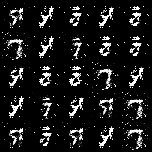

In [13]:
from IPython.display import Image
Image('./images/30000.png')


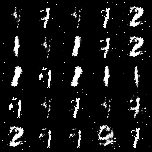

In [14]:
Image('./images/100000.png')